In [1]:
import linecache as lc
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit, repeat
import scipy.stats as st

## Building big file
`train.txt` size is 843 MB

`big_train.txt` size is more 8 GB

In [2]:
path = r"D:\dataset\java-small\java-small\train.txt"
path2 = r"D:\dataset\java-small\java-small\big_train.txt"

In [3]:
# open(path2, "w+").close()
# with open(path, "r", encoding="utf-8") as file:
#     with open(path2, "a+", encoding="utf-8") as file2:
#         for line in file:
#             for i in range(10):
#                 print(f"{i} {line}", file=file2, end="")

In [4]:
path = path2

## LazyByteReader

In [5]:
%%time
cumulative_offset = 0
line_offsets = []
with open(path, "br") as file:
    for line in file:
        line_offsets.append(cumulative_offset)
        cumulative_offset += len(line)
n_samples = len(line_offsets)

Wall time: 38.2 s


In [6]:
def read_line(index):
    with open(path, "br") as file:
        file.seek(line_offsets[index])
        line = file.readline().decode(encoding="utf-8").strip()
    return line

In [7]:
n_samples

25347130

In [8]:
index = 17834923

In [9]:
%%time
read_line(index)

Wall time: 1 ms


'3 {"variable": "uuid", "ngrams": ["Override public void removeByUuid ( String <var> ) { for ( CPDefinitionVirtualSetting cpDefinitionVirtualSetting", "( CPDefinitionVirtualSetting cpDefinitionVirtualSetting : findByUuid ( ( <var> , QueryUtil . ALL_POS ,"], "otherFeatures": [[0], [86]], "psiInterface": "PsiParameter"}'

In [10]:
%%time
stats256 = repeat("""
idxs = np.random.randint(n_samples, size=256)
for idx in idxs:
    read_line(idx)
""",
      number=10, repeat=100, globals=globals())

Wall time: 46.9 s


In [11]:
%%time
stats512 = repeat("""
idxs = np.random.randint(n_samples, size=512)
for idx in idxs:
    read_line(idx)
""",
      number=10, repeat=100, globals=globals())

Wall time: 1min 39s


In [12]:
%%time
stats1024 = repeat("""
idxs = np.random.randint(n_samples, size=1024)
for idx in idxs:
    read_line(idx)
""",
      number=10, repeat=100, globals=globals())

Wall time: 3min 34s


## LazyReader

In [13]:
%%time
len(lc.getlines(path))

Wall time: 36.7 s


25347130

In [14]:
%%time
lc.getline(path, index + 1).strip()

Wall time: 0 ns


'3 {"variable": "uuid", "ngrams": ["Override public void removeByUuid ( String <var> ) { for ( CPDefinitionVirtualSetting cpDefinitionVirtualSetting", "( CPDefinitionVirtualSetting cpDefinitionVirtualSetting : findByUuid ( ( <var> , QueryUtil . ALL_POS ,"], "otherFeatures": [[0], [86]], "psiInterface": "PsiParameter"}'

In [15]:
%%time
lc_stats256 = repeat("""
idxs = np.random.randint(n_samples, size=256)
for idx in idxs:
    lc.getline(path, idx + 1).strip()
""",
      number=10, repeat=100, globals=globals())

Wall time: 10.5 s


In [16]:
%%time
lc_stats512 = repeat("""
idxs = np.random.randint(n_samples, size=512)
for idx in idxs:
    lc.getline(path, idx + 1).strip()
""",
      number=10, repeat=100, globals=globals())

Wall time: 15.8 s


In [17]:
%%time
lc_stats1024 = repeat("""
idxs = np.random.randint(n_samples, size=1024)
for idx in idxs:
    lc.getline(path, idx + 1).strip()
""",
      number=10, repeat=100, globals=globals())

Wall time: 28 s


In [18]:
lc.clearcache()

## Comparison

In [55]:
def compare(stats1, stats2):
    fig, ax = plt.subplots(ncols=1, sharex='all', figsize=(14, 6))
    ax.hist(stats1, bins=20, label="Distribution 1")    
    ax.hist(stats2, bins=20, label="Distribution 2")
    plt.legend()
    plt.show()
    
    print(f"For 1: mean = {np.mean(stats1):.3f}; variance = {np.std(stats1):.3f}")
    print(f"For 2: mean = {np.mean(stats2):.3f}; variance = {np.std(stats2):.3f}\n")
    
    print("\nLet's check equality of means via Welch’s t-test:")
    print(st.ttest_ind(stats1, stats2, equal_var=False))

Distribution 1 -- `read_line`, distribution 2 -- `lc.getline`. Mean time of reading batch is `np.mean(stats) / 10`.

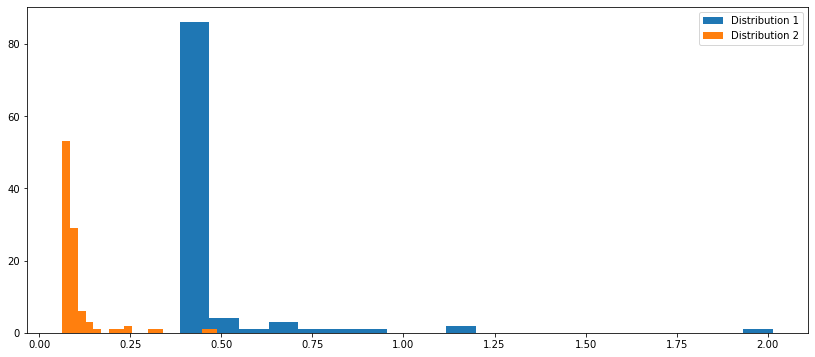

For 1: mean = 0.469; variance = 0.204
For 2: mean = 0.105; variance = 0.069


Let's check equality of means via Welch’s t-test:
Ttest_indResult(statistic=16.793296077742287, pvalue=2.0924376400917102e-33)


In [56]:
compare(stats256, lc_stats256)

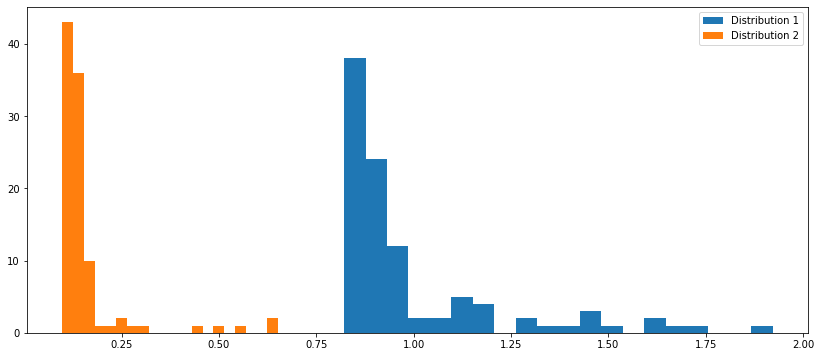

For 1: mean = 0.993; variance = 0.233
For 2: mean = 0.157; variance = 0.100


Let's check equality of means via Welch’s t-test:
Ttest_indResult(statistic=32.7231398164242, pvalue=6.53018274401535e-66)


In [57]:
compare(stats512, lc_stats512)

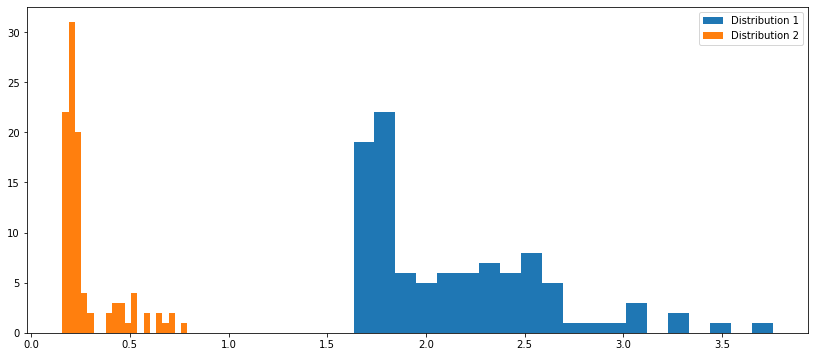

For 1: mean = 2.140; variance = 0.461
For 2: mean = 0.281; variance = 0.147


Let's check equality of means via Welch’s t-test:
Ttest_indResult(statistic=38.22024129891425, pvalue=1.201844581154238e-68)


In [58]:
compare(stats1024, lc_stats1024)

`pvalue < 1%` hence `lc.getline` might be a way to go.

P.S. Perhaps statistical tests are unnecessary here.